# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.saving import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Предобработка данных

In [2]:
data_path = '/content/drive/MyDrive/Colab Notebooks/ВКР/chest_xray/'

In [3]:
classes = os.listdir(data_path)

In [4]:
def plot_class(path):
    plt.figure(figsize=(12,12))
    title = path.split('/')[-1]
    for i in range(1,5):
        plt.subplot(1,4,i)
        plt.tight_layout()
        rand_img = plt.imread(path +'/'+ random.choice(sorted(os.listdir(path))))
        plt.imshow(rand_img)
        plt.title(title, fontsize=15, color='blue')
        plt.xticks([])
        plt.yticks([])

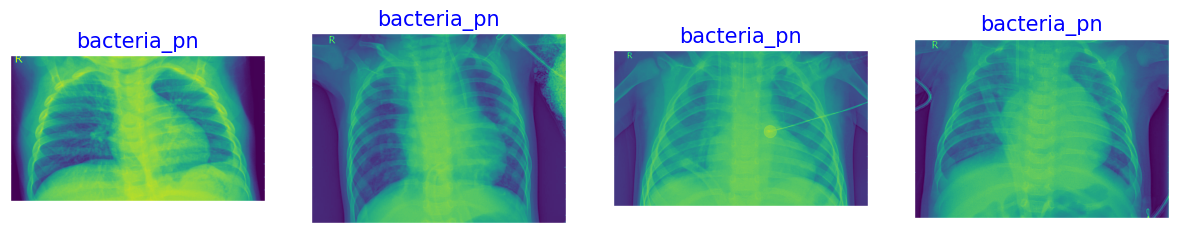

In [5]:
plot_class(data_path+classes[0])

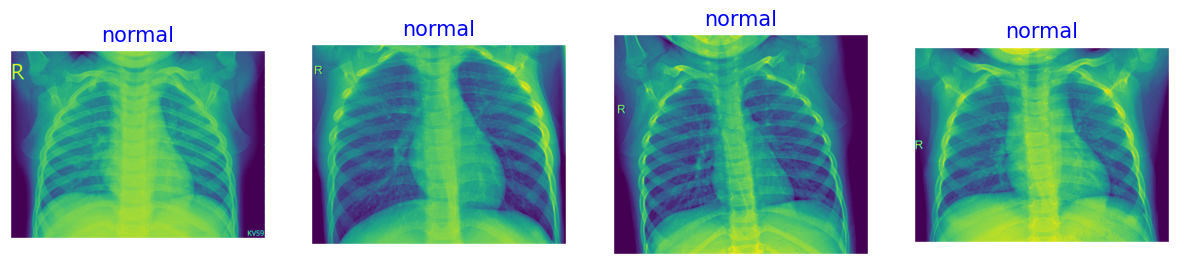

In [6]:
plot_class(data_path+classes[1])

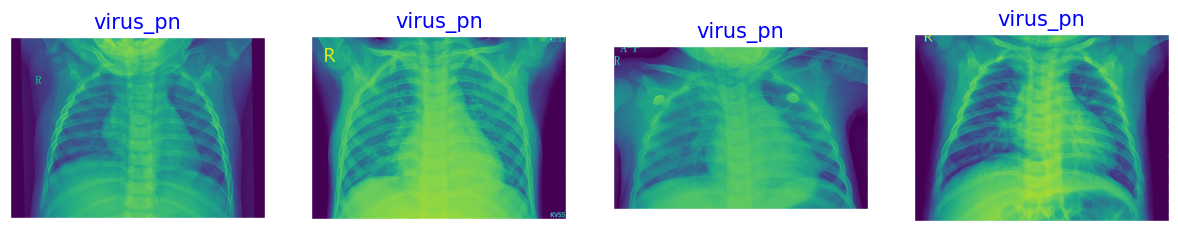

In [7]:
plot_class(data_path+classes[2])

In [8]:
def main(train_data_path):
    
    for dirs in [train_data_path]:

        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))

        filepaths,labels = get_fileList(classes_list, dirs, filepaths, labels)
        
        train_df = obtain_train_df(filepaths, labels)
        
            
    return train_df



def get_fileList(classes_list, dirs, filepaths, labels):

    for s_class in classes_list:
        
        label = s_class
        classpath = os.path.join(dirs, s_class)
        flist = sorted(os.listdir(classpath))
        
        store_image_names_and_its_labels(flist, classpath, filepaths, labels, label)
        
    return filepaths, labels


def store_image_names_and_its_labels(flist, classpath, filepaths, labels, label):
    
    for file in flist:
        file_path = os.path.join(classpath, file)
        filepaths.append(file_path)
        labels.append(label)



def obtain_train_df(filepaths, labels):

    train_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return train_df

In [9]:
data_df = main(data_path)

In [10]:
data_df.head()

,image_path,label
0,/content/drive/MyDrive/Colab Notebooks/ВКР/che...,bacteria_pn
1,/content/drive/MyDrive/Colab Notebooks/ВКР/che...,bacteria_pn
2,/content/drive/MyDrive/Colab Notebooks/ВКР/che...,bacteria_pn
3,/content/drive/MyDrive/Colab Notebooks/ВКР/che...,bacteria_pn
4,/content/drive/MyDrive/Colab Notebooks/ВКР/che...,bacteria_pn


In [11]:
num_classes = len(data_df['label'].unique())
print(f"We have {num_classes} classes")
print(f"We have {data_df.shape[0]} images")

We have 3 classes
We have 5856 images


In [12]:
data_df['label'].value_counts()

bacteria_pn    2780
normal         1583
virus_pn       1493
Name: label, dtype: int64

In [13]:
def count_plot(x, title, xlabel, ylabel, width, length, order = None, rotation=False, palette='winter'):
    plt.figure(figsize=(width,length))
    sns.countplot(x = x, palette=palette, order = order)
    plt.title(title, fontsize=25)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

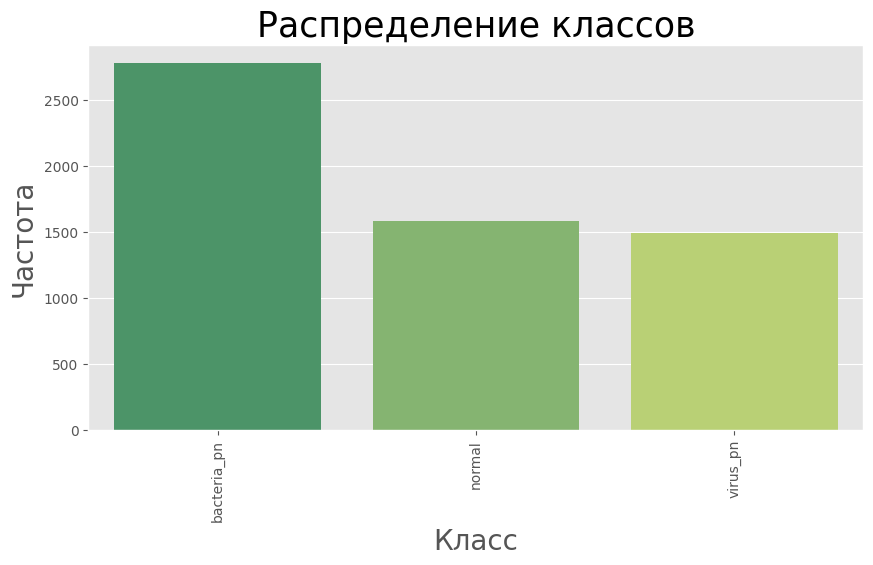

In [14]:
x = data_df['label']
order = x.value_counts().index
count_plot(x, "Распределение классов", "Класс", 'Частота', 10,5, rotation = True, order=order, palette='summer')

In [15]:
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            fold = str(fold).replace('C+', '')
            labels.append(fold[:-3])

    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

In [16]:
def tr_ts_data(tr_dir, ts_dir):
    
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    files, classes = define_paths(tr_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

def full_data(data_dir):

    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

def tr_val_ts_data(tr_dir, val_dir, ts_dir):

    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)

    return train_df, valid_df, test_df

In [17]:
def split_data(tr_dir, val_dir=None, ts_dir=None):

    if val_dir == '' and ts_dir == '':
        train_df, valid_df, test_df = full_data(tr_dir)
        return train_df, valid_df, test_df

    elif val_dir == '' and ts_dir != '':
        train_df, valid_df, test_df = tr_ts_data(tr_dir, ts_dir)
        return train_df, valid_df, test_df

    elif val_dir != '' and ts_dir != '':
        train_df, valid_df, test_df = tr_val_ts_data(tr_dir, val_dir, ts_dir)
        return train_df, valid_df, test_df

In [18]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, 
                                horizontal_flip= True)
    
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, 
                                           x_col= 'filepaths', 
                                           y_col= 'labels', 
                                           target_size= img_size, 
                                           class_mode= 'categorical',
                                           color_mode= color, 
                                           shuffle= True, 
                                           batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, 
                                           x_col= 'filepaths', 
                                           y_col= 'labels', 
                                           target_size= img_size, 
                                           class_mode= 'categorical',
                                           color_mode= color, 
                                           shuffle= True, 
                                           batch_size= batch_size)

    test_gen = ts_gen.flow_from_dataframe( test_df, 
                                          x_col= 'filepaths', 
                                          y_col= 'labels', 
                                          target_size= img_size, 
                                          class_mode= 'categorical',
                                          color_mode= color, 
                                          shuffle= False, 
                                          batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [19]:
def show_images(gen):

    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels) 
    sample = min(length, 25)  

    plt.figure(figsize= (10, 10))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255      
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]  
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()
    


In [20]:
def plot_label_count(df, plot_title):

    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    lcount = len(labels)

    if lcount > 55:
        print('The number of labels is > 55, no plot will be produced')

    else:
        plot_labels(lcount, labels, values, plot_title)

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width, 20])

    plt.figure(figsize= (width, 5))

    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    sns.barplot(x=labels, y=values)
    plt.title(f'Images per Label in {plot_title} data', fontsize= 24, color= 'blue')
    plt.xticks(rotation= 90, fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.xlabel('CLASS', fontdict= form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict= form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize= 12,
                rotation= rotation, color= 'yellow', ha= 'center')

    plt.show()

In [21]:
train_dir = data_path
valid_dir = input('Enter validation data directory (if no valid dir press Enter): ')
test_dir = input('Enter test data directory (if no test dir press Enter): ')

train_df, valid_df, test_df = split_data(train_dir, valid_dir, test_dir)

batch_size = 32
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

Enter validation data directory (if no valid dir press Enter): 
Enter test data directory (if no test dir press Enter): 
Found 4684 validated image filenames belonging to 3 classes.
Found 586 validated image filenames belonging to 3 classes.
Found 586 validated image filenames belonging to 3 classes.


In [22]:
train_gen.class_indices

{'bacteria': 0, 'nor': 1, 'virus': 2}

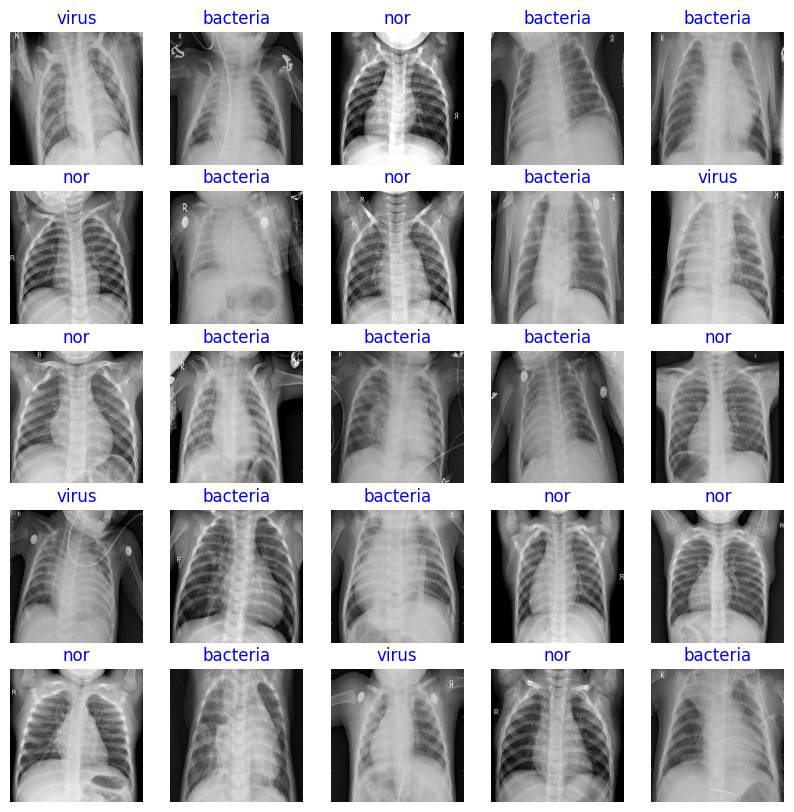

In [ ]:
show_images(train_gen)

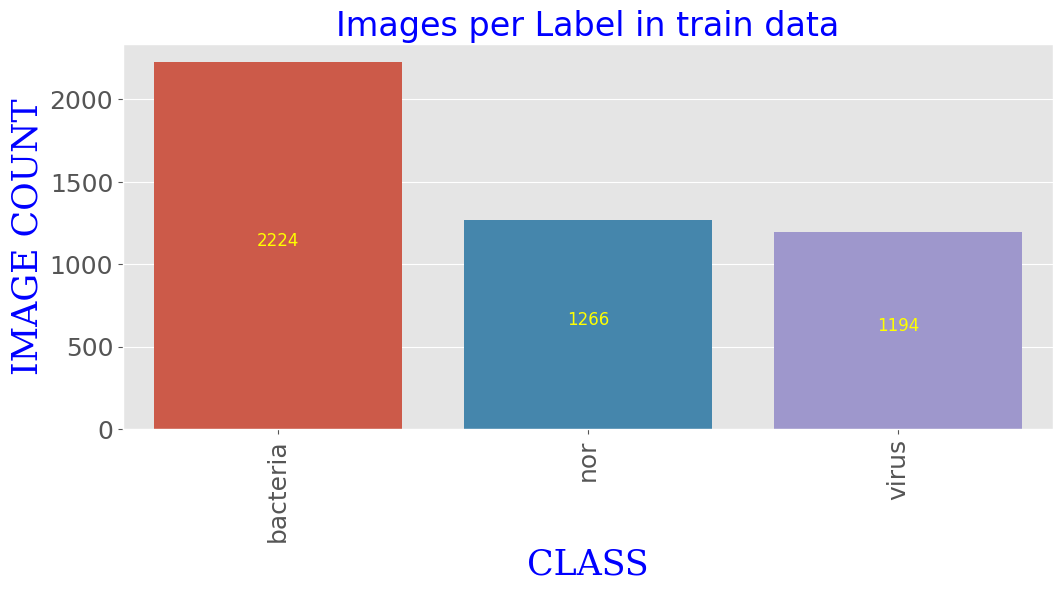

In [ ]:
plot_label_count(train_df, 'train')

# Обучение моделей

In [ ]:
def plot_training(hist):

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (15, 6))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 100, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 100, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()



## Модель EfficientNet

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

115263384/115263384 [==============================] - 4s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 29,047,034
Trainable params: 28,870,195
Non-trainable params: 176,839
______________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/xray_EfficientNetB5_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
147/147 [==============================] - ETA: 0s - loss: 7.2215 - accuracy: 0.7165
Epoch 1: val_loss improved from inf to 5.88211, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_EfficientNetB5_model_weights.h5
147/147 [==============================] - 1724s 11s/step - loss: 7.2215 - accuracy: 0.7165 - val_loss: 5.8821 - val_accuracy: 0.8072
Epoch 2/20
147/147 [==============================] - ETA: 0s - loss: 4.5400 - accuracy: 0.8072
Epoch 2: val_loss improved from 5.88211 to 3.95805, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_EfficientNetB5_model_weights.h5
147/147 [==============================] - 147s 994ms/step - loss: 4.5400 - accuracy: 0.8072 - val_loss: 3.9580 - val_accuracy: 0.7884
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 3.2126 - accuracy: 0.8431
Epoch 3: val_loss improved from 3.95805 to 2.85506, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_EfficientNetB5_model_weights.h5
147

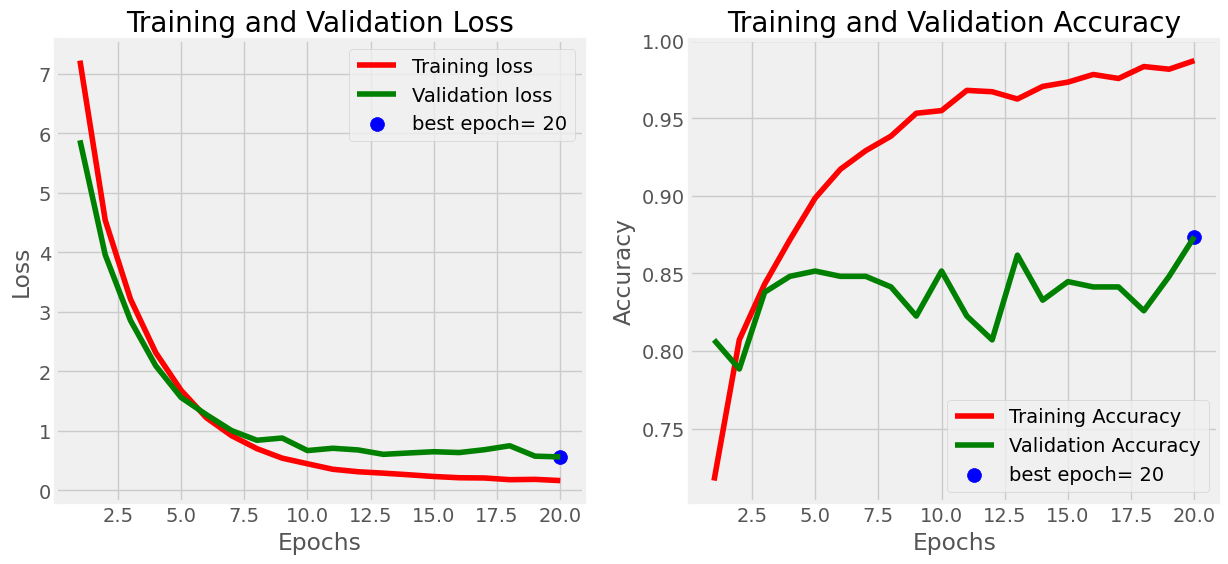

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

147/293 [==============>...............] - ETA: 1:07 - loss: 0.1236 - accuracy: 0.9981

 19/293 [>.............................] - ETA: 2:00 - loss: 0.5628 - accuracy: 0.8737

293/293 [==============================] - 186s 633ms/step - loss: 0.7067 - accuracy: 0.8328
Train Loss:  0.12357088923454285
Train Accuracy:  0.9980785846710205
--------------------
Validation Loss:  0.5628284811973572
Validation Accuracy:  0.873720109462738
--------------------
Test Loss:  0.7066624164581299
Test Accuracy:  0.8327645063400269


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

293/293 [==============================] - 15s 37ms/step


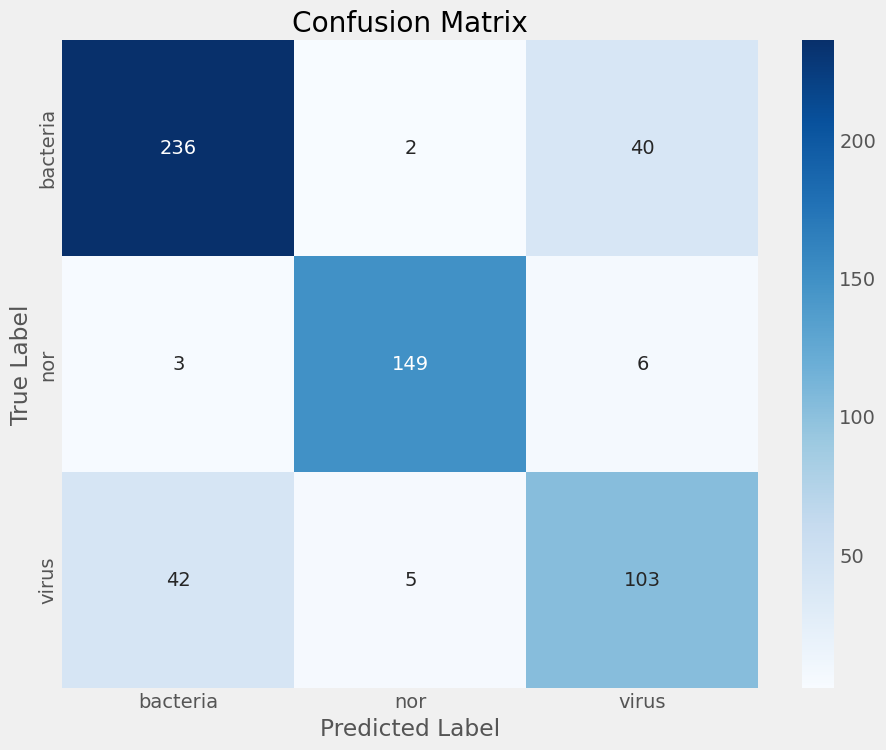

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
              precision    recall  f1-score   support

    bacteria       0.84      0.85      0.84       278
         nor       0.96      0.94      0.95       158
       virus       0.69      0.69      0.69       150

    accuracy                           0.83       586
   macro avg       0.83      0.83      0.83       586
weighted avg       0.83      0.83      0.83       586



## Модель ConvNeXt

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.convnext.ConvNeXtTiny(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

111650432/111650432 [==============================] - 4s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 768)               27820128  
                                                                 
 batch_normalization_1 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               196864    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 28,020,835
Trainable params: 28,019,299
Non-trainable params: 1,536
______________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/xray_ConvNext_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
147/147 [==============================] - ETA: 0s - loss: 5.8813 - accuracy: 0.7143
Epoch 1: val_loss improved from inf to 5.13857, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_ConvNext_model_weights.h5
147/147 [==============================] - 186s 925ms/step - loss: 5.8813 - accuracy: 0.7143 - val_loss: 5.1386 - val_accuracy: 0.4744
Epoch 2/20
147/147 [==============================] - ETA: 0s - loss: 3.7471 - accuracy: 0.7921
Epoch 2: val_loss improved from 5.13857 to 3.49213, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_ConvNext_model_weights.h5
147/147 [==============================] - 121s 821ms/step - loss: 3.7471 - accuracy: 0.7921 - val_loss: 3.4921 - val_accuracy: 0.4846
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 2.5615 - accuracy: 0.8076
Epoch 3: val_loss improved from 3.49213 to 2.52169, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_ConvNext_model_weights.h5
147/147 [===========

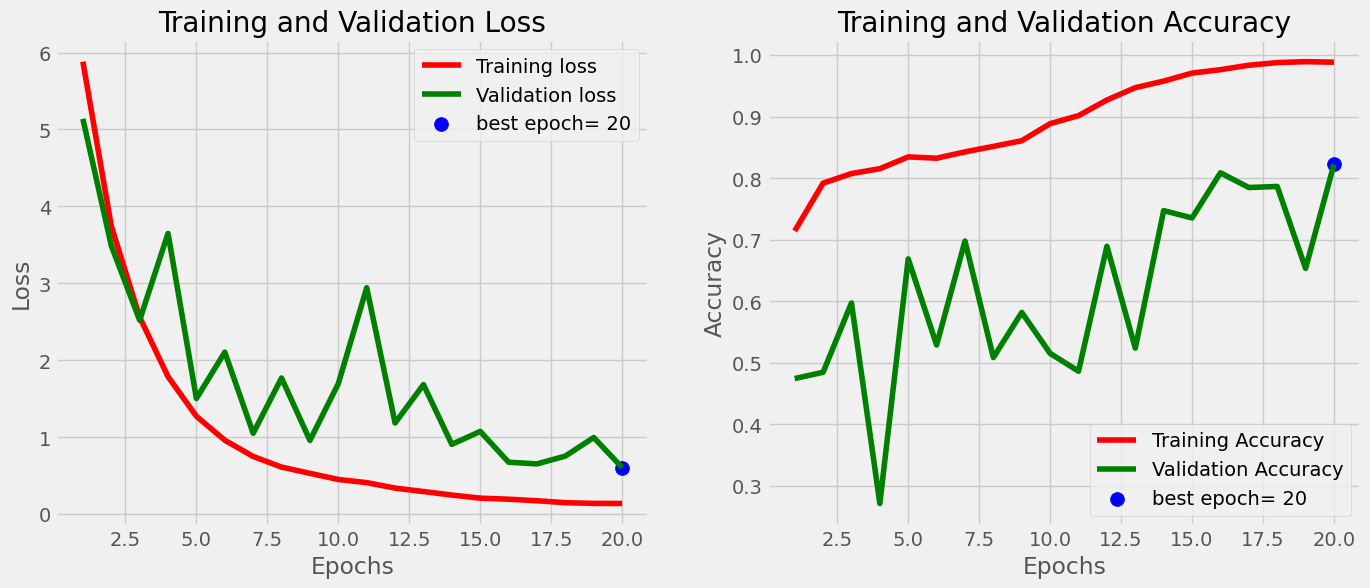

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

147/293 [==============>...............] - ETA: 1:09 - loss: 0.1263 - accuracy: 0.9942

 19/293 [>.............................] - ETA: 2:00 - loss: 0.6065 - accuracy: 0.8225

293/293 [==============================] - 17s 50ms/step - loss: 0.6071 - accuracy: 0.8259
Train Loss:  0.12626178562641144
Train Accuracy:  0.9942356944084167
--------------------
Validation Loss:  0.6065248250961304
Validation Accuracy:  0.8225256204605103
--------------------
Test Loss:  0.6070552468299866
Test Accuracy:  0.8259385824203491


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

293/293 [==============================] - 16s 50ms/step


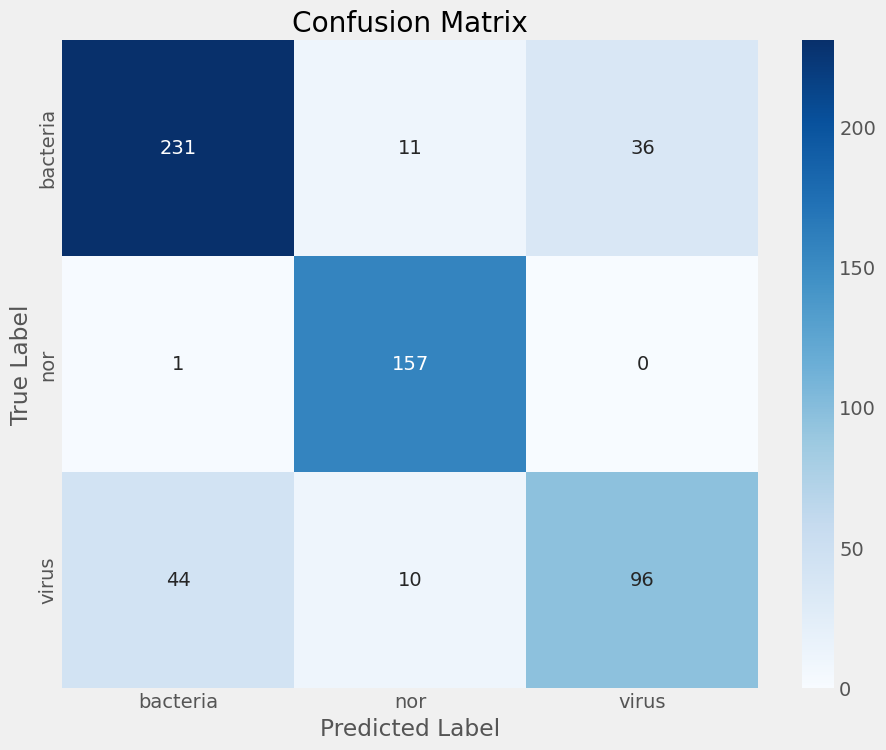

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
              precision    recall  f1-score   support

    bacteria       0.84      0.83      0.83       278
         nor       0.88      0.99      0.93       158
       virus       0.73      0.64      0.68       150

    accuracy                           0.83       586
   macro avg       0.82      0.82      0.82       586
weighted avg       0.82      0.83      0.82       586



## Модель Xception

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.xception.Xception(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,394,987
Trainable params: 21,336,363
Non-trainable params: 58,624
_______________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/xray_Xception_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
147/147 [==============================] - ETA: 0s - loss: 6.4642 - accuracy: 0.7485
Epoch 1: val_loss improved from inf to 5.17833, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_Xception_model_weights.h5
147/147 [==============================] - 1566s 10s/step - loss: 6.4642 - accuracy: 0.7485 - val_loss: 5.1783 - val_accuracy: 0.7014
Epoch 2/20
147/147 [==============================] - ETA: 0s - loss: 3.9345 - accuracy: 0.8316
Epoch 2: val_loss improved from 5.17833 to 3.20161, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_Xception_model_weights.h5
147/147 [==============================] - 92s 623ms/step - loss: 3.9345 - accuracy: 0.8316 - val_loss: 3.2016 - val_accuracy: 0.8174
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 2.5783 - accuracy: 0.8593
Epoch 3: val_loss improved from 3.20161 to 2.30581, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_Xception_model_weights.h5
147/147 [=============

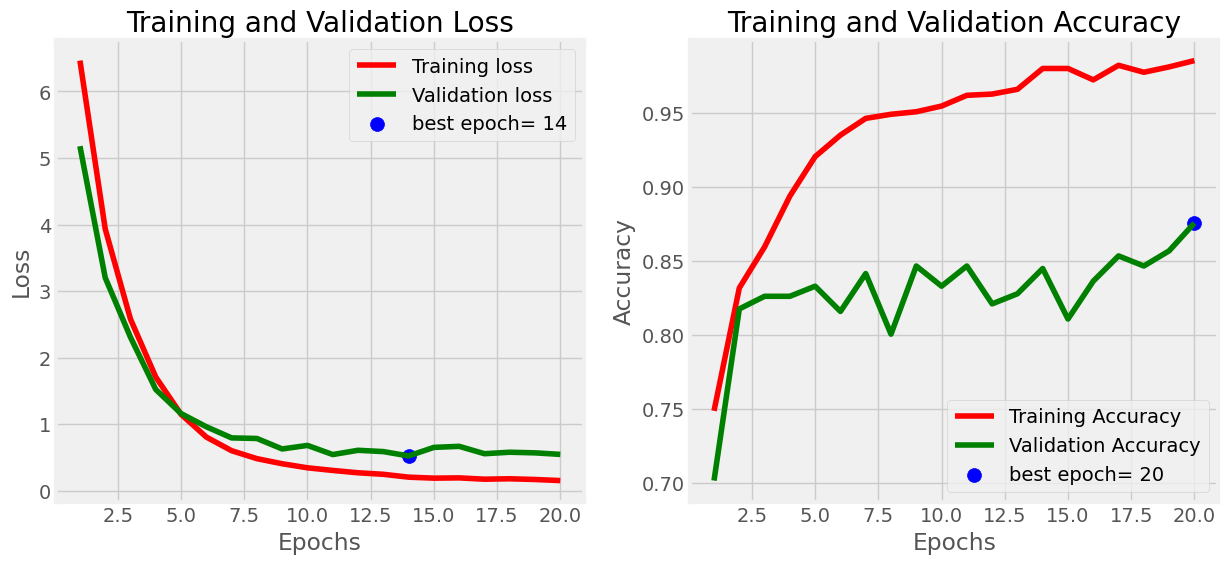

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

147/293 [==============>...............] - ETA: 1:04 - loss: 0.1141 - accuracy: 0.9962

 19/293 [>.............................] - ETA: 1:47 - loss: 0.5462 - accuracy: 0.8754

293/293 [==============================] - 169s 578ms/step - loss: 0.6239 - accuracy: 0.8515
Train Loss:  0.11408626288175583
Train Accuracy:  0.9961571097373962
--------------------
Validation Loss:  0.5461686253547668
Validation Accuracy:  0.8754266500473022
--------------------
Test Loss:  0.6238559484481812
Test Accuracy:  0.8515358567237854


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

293/293 [==============================] - 11s 35ms/step


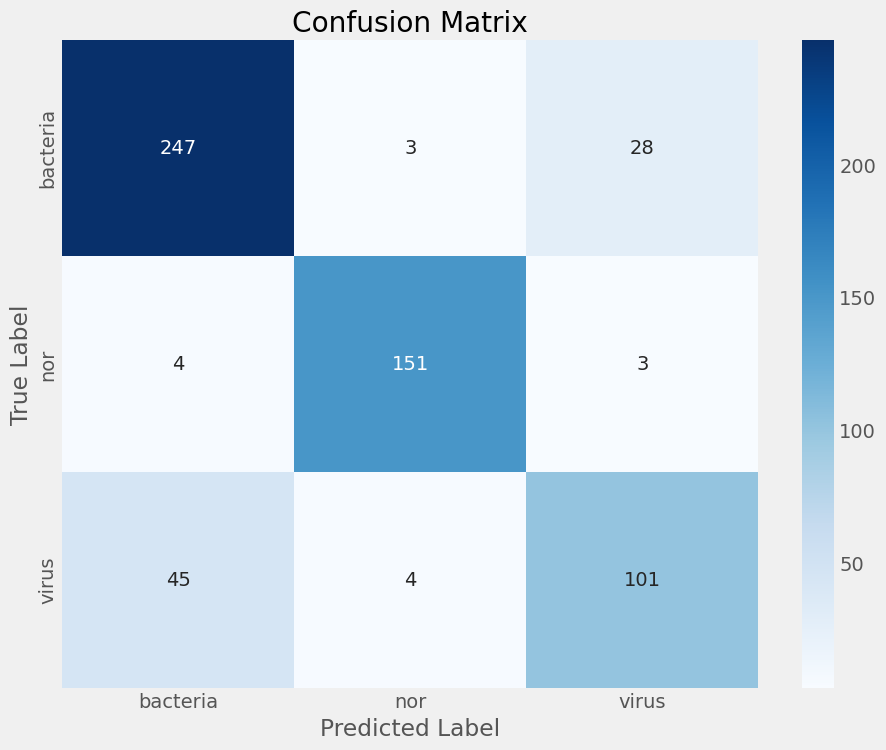

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
              precision    recall  f1-score   support

    bacteria       0.83      0.89      0.86       278
         nor       0.96      0.96      0.96       158
       virus       0.77      0.67      0.72       150

    accuracy                           0.85       586
   macro avg       0.85      0.84      0.84       586
weighted avg       0.85      0.85      0.85       586



## Модель NasNet

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.nasnet.NASNetMobile(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

19993432/19993432 [==============================] - 1s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 1056)              4269716   
                                                                 
 batch_normalization_5 (Batc  (None, 1056)             4224      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               270592    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 4,545,303
Trainable params: 4,506,453
Non-trainable params: 38,850
_______________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/xray_NasNet_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
147/147 [==============================] - ETA: 0s - loss: 6.4774 - accuracy: 0.7233
Epoch 1: val_loss improved from inf to 6.27445, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_NasNet_model_weights.h5
147/147 [==============================] - 222s 597ms/step - loss: 6.4774 - accuracy: 0.7233 - val_loss: 6.2744 - val_accuracy: 0.4113
Epoch 2/20
147/147 [==============================] - ETA: 0s - loss: 4.1669 - accuracy: 0.8164
Epoch 2: val_loss improved from 6.27445 to 4.29712, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_NasNet_model_weights.h5
147/147 [==============================] - 82s 555ms/step - loss: 4.1669 - accuracy: 0.8164 - val_loss: 4.2971 - val_accuracy: 0.4454
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 2.9522 - accuracy: 0.8341
Epoch 3: val_loss improved from 4.29712 to 3.34768, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_NasNet_model_weights.h5
147/147 [==================

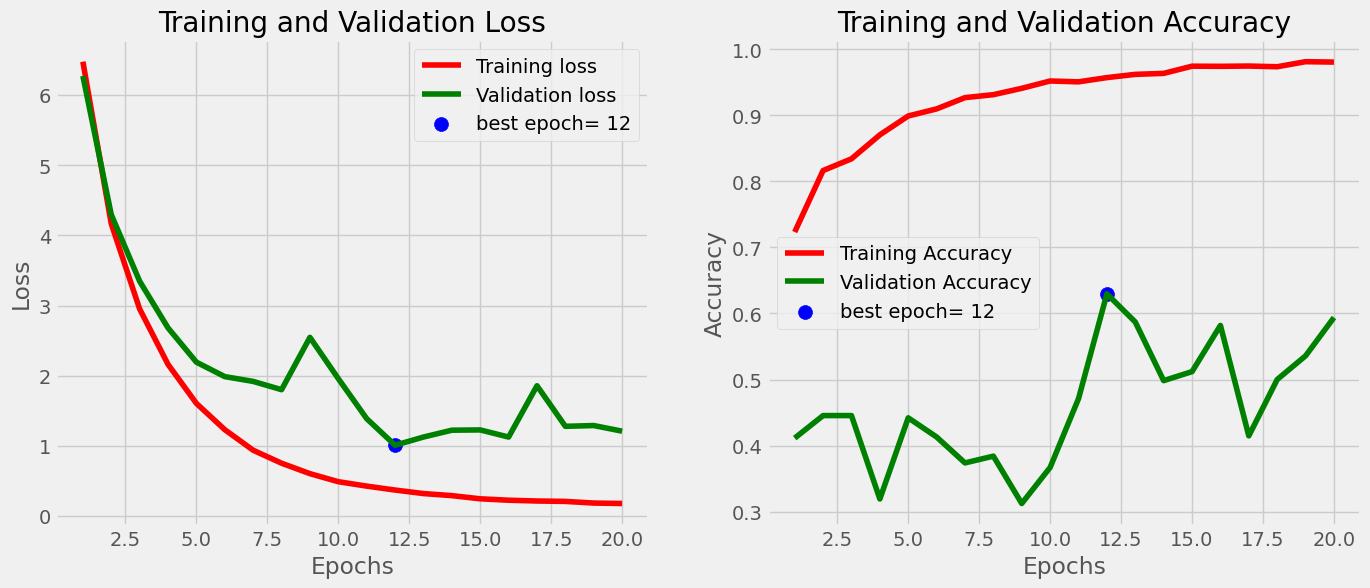

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

147/293 [==============>...............] - ETA: 1:02 - loss: 1.0269 - accuracy: 0.6396

 19/293 [>.............................] - ETA: 1:45 - loss: 1.2103 - accuracy: 0.5939

293/293 [==============================] - 12s 41ms/step - loss: 1.1342 - accuracy: 0.6143
Train Loss:  1.0268986225128174
Train Accuracy:  0.6396242380142212
--------------------
Validation Loss:  1.2103147506713867
Validation Accuracy:  0.5938566327095032
--------------------
Test Loss:  1.1341886520385742
Test Accuracy:  0.6143344640731812


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

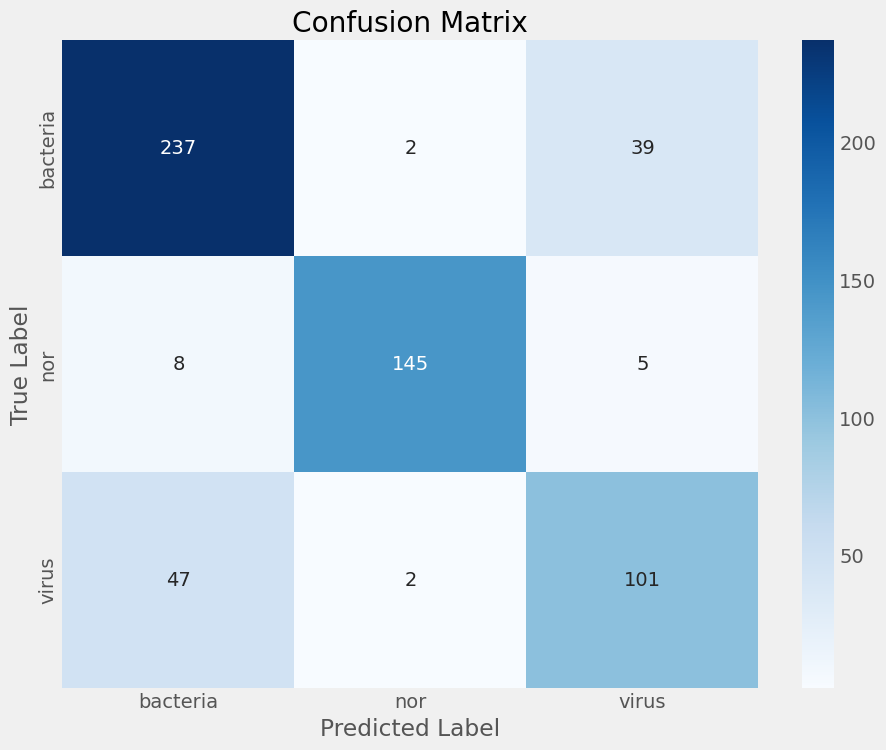

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
              precision    recall  f1-score   support

    bacteria       0.82      0.36      0.50       278
         nor       0.73      0.96      0.83       158
       virus       0.42      0.72      0.53       150

    accuracy                           0.61       586
   macro avg       0.66      0.68      0.62       586
weighted avg       0.69      0.61      0.60       586



## Модель InceptionResNetV2

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 batch_normalization_209 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 256)               393472    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 54,737,123
Trainable params: 54,673,507


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/xray_InceptionResNetV2_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
147/147 [==============================] - ETA: 0s - loss: 6.7235 - accuracy: 0.7372
Epoch 1: val_loss improved from inf to 5.59175, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_InceptionResNetV2_model_weights.h5
147/147 [==============================] - 197s 721ms/step - loss: 6.7235 - accuracy: 0.7372 - val_loss: 5.5918 - val_accuracy: 0.7372
Epoch 2/20
147/147 [==============================] - ETA: 0s - loss: 4.8391 - accuracy: 0.8061
Epoch 2: val_loss improved from 5.59175 to 4.22542, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_InceptionResNetV2_model_weights.h5
147/147 [==============================] - 97s 656ms/step - loss: 4.8391 - accuracy: 0.8061 - val_loss: 4.2254 - val_accuracy: 0.8089
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 3.7274 - accuracy: 0.8330
Epoch 3: val_loss improved from 4.22542 to 3.35333, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/xray_InceptionResNetV2_model_weigh

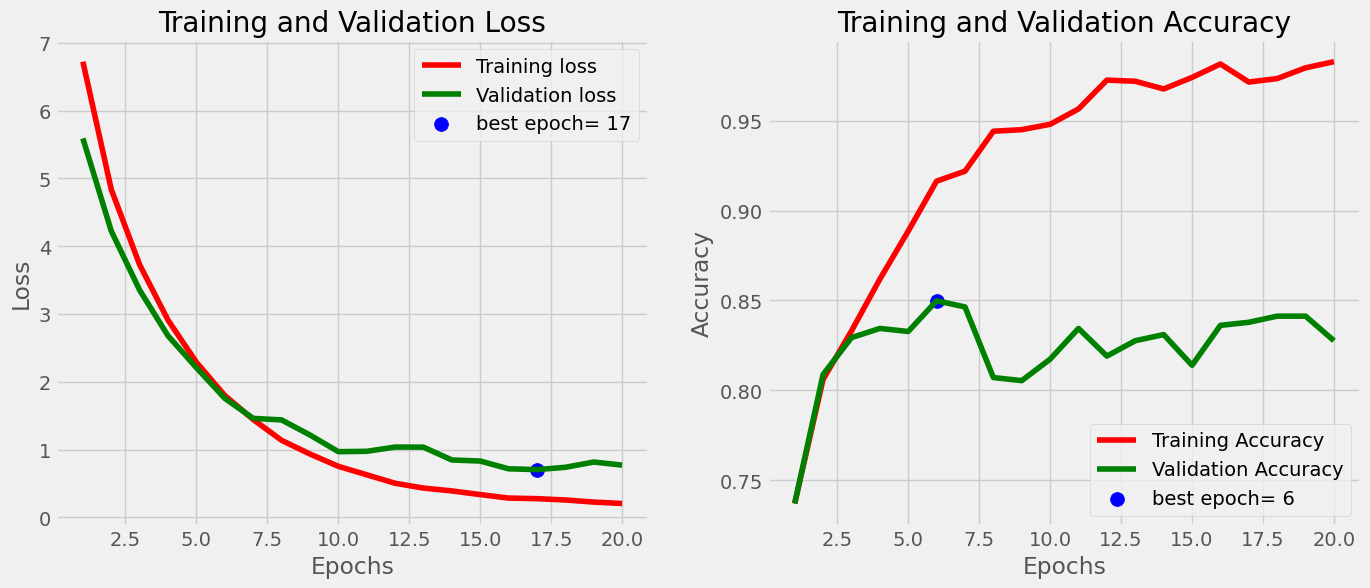

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

147/293 [==============>...............] - ETA: 1:05 - loss: 0.2609 - accuracy: 0.9955

 19/293 [>.............................] - ETA: 1:45 - loss: 0.7712 - accuracy: 0.8276

293/293 [==============================] - 15s 47ms/step - loss: 0.7783 - accuracy: 0.8242
Train Loss:  0.2608852684497833
Train Accuracy:  0.9955166578292847
--------------------
Validation Loss:  0.7711998224258423
Validation Accuracy:  0.8276450634002686
--------------------
Test Loss:  0.778252363204956
Test Accuracy:  0.8242321014404297


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

293/293 [==============================] - 26s 89ms/step


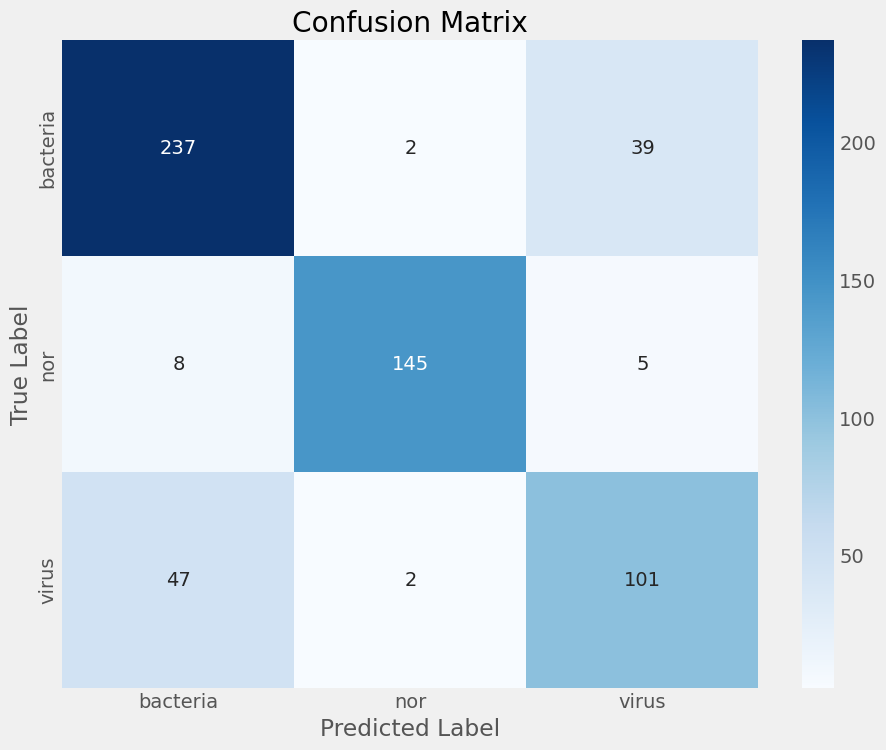

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
              precision    recall  f1-score   support

    bacteria       0.81      0.85      0.83       278
         nor       0.97      0.92      0.94       158
       virus       0.70      0.67      0.68       150

    accuracy                           0.82       586
   macro avg       0.83      0.81      0.82       586
weighted avg       0.83      0.82      0.82       586

